# Import Packages


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score  # For R-squared evaluation
from sklearn.model_selection import train_test_split  # For splitting data
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


# RNN

In [2]:
# Define the updated RNN model with multiple layers and dropout
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        """
        Initialize the RNNModel class.

        Parameters:
        - input_size (int): Number of input features per time step (e.g., 1 for univariate time series).
        - hidden_size (int): Number of hidden units in the RNN layer.
        - output_size (int): Number of output features (e.g., 1 for univariate prediction).
        - num_layers (int): Number of RNN layers. Default is 2, meaning we stack two RNN layers.
        - dropout (float): The dropout rate between RNN layers to prevent overfitting. Default is 0.2 (20% dropout).
        """
        super(RNNModel, self).__init__()  # Initialize the parent class (nn.Module)

        # RNN layer with specified input size, hidden size, and number of layers
        # 'batch_first=True' means that the input tensor will be in the form (batch, seq_len, input_size)
        # Dropout is applied only between RNN layers to avoid overfitting and enhance generalization
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer that transforms the hidden state to the output space
        # The output from the RNN is of size (batch, seq_len, hidden_size)
        # The fully connected layer takes the last hidden state's output (at the last time step) and maps it to the desired output size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model. The input is passed through the RNN and then through the fully connected layer.

        Parameters:
        - x (Tensor): Input tensor with shape (batch_size, sequence_length, input_size)

        Returns:
        - out (Tensor): The output after passing through the RNN and fully connected layer. Shape: (batch_size, output_size)
        """
        # Pass input through the RNN layer
        # The output 'out' contains the hidden states for each time step in the sequence.
        # The second value (_) is the hidden state of the last time step (which we do not need here).
        out, _ = self.rnn(x)

        # Take the output from the last time step in the sequence.
        # out[:, -1, :] selects the last time step of each batch, where '-1' refers to the last element.
        # The `:` after `-1` refers to the entire hidden state vector at that time step.
        out = self.fc(out[:, -1, :])  # Pass the last time step's output through the fully connected layer

        return out  # Return the output, which has shape (batch_size, output_size)



In [3]:
def create_dataset(data, seq_length):
    """
    Converts raw time series data into a supervised learning dataset for RNNs or similar models.

    Parameters:
    - data (array-like): The raw time series data, a 1D array or list of values.
    - seq_length (int): The length of each input sequence (number of time steps).

    Returns:
    - x (numpy array): A 2D array where each row represents an input sequence of `seq_length` time steps.
    - y (numpy array): A 1D array where each element is the target value corresponding to the next time step
                       following the input sequence.
    """

    # Initialize empty lists to store input sequences (x) and target values (y)
    x, y = [], []

    # Iterate through the time series data to create sliding windows of input-output pairs
    for i in range(len(data) - seq_length):
        # Extract a sequence of `seq_length` consecutive time steps as input
        # Example: if seq_length = 3, for data = [1, 2, 3, 4, 5], x will store sequences like [1, 2, 3], [2, 3, 4]
        x.append(data[i:i + seq_length])

        # Extract the value immediately following the sequence as the target (output)
        # Example: for the sequence [1, 2, 3], the corresponding target will be 4
        y.append(data[i + seq_length])

    # Convert the lists of input sequences and targets into numpy arrays
    # This makes them compatible with machine learning frameworks like PyTorch or TensorFlow
    return np.array(x), np.array(y)


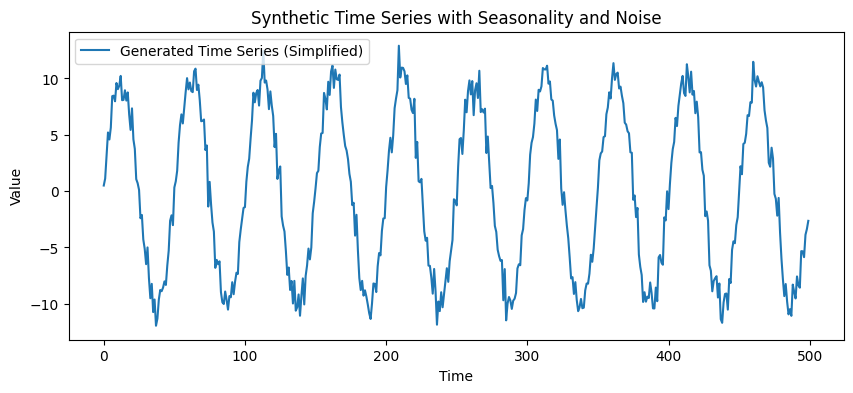

In [4]:
# Generate simplified synthetic time series data with seasonality and noise
np.random.seed(42)  # Set random seed for reproducibility
data_length = 500  # Total length of the time series
time = np.arange(0, data_length)

# Create the seasonal component (sine wave with period of 50 time steps)
seasonal_component = 10 * np.sin(2 * np.pi * time / 50)

# Add random noise to the seasonal component
noise = np.random.normal(0, 1, size=data_length)  # Random noise

# Combine the seasonal and noise components
data = seasonal_component + noise

# Plot the generated dataset
plt.figure(figsize=(10, 4))
plt.plot(time, data, label="Generated Time Series (Simplified)")
plt.title("Synthetic Time Series with Seasonality and Noise")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [5]:
# Initialize the RNN model
input_size = 1  # We have a univariate time series (1 feature)
hidden_size = 64  # Number of hidden units in the RNN
output_size = 1  # We're predicting one value at a time
num_layers = 2  # Number of RNN layers
dropout = 0.2  # Dropout to prevent overfitting

model = RNNModel(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Set sequence length
seq_length = 50

# Prepare the dataset
x, y = create_dataset(data, seq_length)

# Reshape inputs for RNN compatibility: (samples, seq_length, features)
x = x.reshape(-1, seq_length, 1)

In [7]:
# Define split indices
train_size = int(0.7 * len(x))  # 70% for training
val_size = int(0.15 * len(x))   # 15% for validation
test_size = len(x) - train_size - val_size  # 15% for testing

# Sequential split
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Verify the sizes of each split
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")


Training set size: 315
Validation set size: 67
Test set size: 68


In [8]:
# Convert data to PyTorch tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# Set up the optimizer and loss function
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Lists to store losses for graphing
train_losses = []
val_losses = []

# Training loop
epochs = 50
batch_size = 64
print("Training the model...")
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    # Enable progress bar
    with tqdm(total=len(x_train_tensor), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for i in range(0, len(x_train_tensor), batch_size):
            # Get the batch
            batch_x = x_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running training loss
            running_train_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(len(batch_x))

    # Average training loss for the epoch
    avg_train_loss = running_train_loss / (len(x_train_tensor) // batch_size)
    train_losses.append(avg_train_loss)

    # Validate the model after each epoch
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_r2 = r2_score(y_val_tensor.cpu(), val_outputs.cpu())

    # Store the validation loss for graphing
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {val_loss.item():.4f} - Validation R2: {val_r2:.4f}")



Training the model...


Epoch 1/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 56.0734 - Validation Loss: 34.0313 - Validation R2: 0.2969


Epoch 2/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 41.4493 - Validation Loss: 24.6194 - Validation R2: 0.4914


Epoch 3/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 30.5895 - Validation Loss: 18.4602 - Validation R2: 0.6186


Epoch 4/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 23.3442 - Validation Loss: 14.3573 - Validation R2: 0.7034


Epoch 5/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 18.4294 - Validation Loss: 11.2163 - Validation R2: 0.7683


Epoch 6/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 14.6854 - Validation Loss: 9.1455 - Validation R2: 0.8111


Epoch 7/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 12.2656 - Validation Loss: 7.9934 - Validation R2: 0.8349


Epoch 8/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 10.6547 - Validation Loss: 7.1543 - Validation R2: 0.8522


Epoch 9/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 9.5028 - Validation Loss: 6.5626 - Validation R2: 0.8644


Epoch 10/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 8.5392 - Validation Loss: 6.0395 - Validation R2: 0.8752


Epoch 11/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 7.8527 - Validation Loss: 5.5959 - Validation R2: 0.8844


Epoch 12/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 7.2507 - Validation Loss: 5.2230 - Validation R2: 0.8921


Epoch 13/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 6.7514 - Validation Loss: 4.8798 - Validation R2: 0.8992


Epoch 14/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 6.3360 - Validation Loss: 4.5255 - Validation R2: 0.9065


Epoch 15/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 5.8105 - Validation Loss: 4.1590 - Validation R2: 0.9141


Epoch 16/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 5.3647 - Validation Loss: 3.8096 - Validation R2: 0.9213


Epoch 17/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 5.0221 - Validation Loss: 3.4764 - Validation R2: 0.9282


Epoch 18/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 4.5773 - Validation Loss: 3.1455 - Validation R2: 0.9350


Epoch 19/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 4.1299 - Validation Loss: 2.8284 - Validation R2: 0.9416


Epoch 20/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 3.7848 - Validation Loss: 2.6274 - Validation R2: 0.9457


Epoch 21/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 3.5699 - Validation Loss: 2.4148 - Validation R2: 0.9501


Epoch 22/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 3.3222 - Validation Loss: 2.3893 - Validation R2: 0.9506


Epoch 23/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 3.0894 - Validation Loss: 2.1580 - Validation R2: 0.9554


Epoch 24/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 2.9685 - Validation Loss: 1.9961 - Validation R2: 0.9588


Epoch 25/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 2.7107 - Validation Loss: 2.1348 - Validation R2: 0.9559


Epoch 26/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 2.8085 - Validation Loss: 1.9239 - Validation R2: 0.9603


Epoch 27/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 2.5625 - Validation Loss: 1.7373 - Validation R2: 0.9641


Epoch 28/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 2.3722 - Validation Loss: 2.0415 - Validation R2: 0.9578


Epoch 29/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 2.3849 - Validation Loss: 1.5968 - Validation R2: 0.9670


Epoch 30/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 2.3422 - Validation Loss: 1.7067 - Validation R2: 0.9647


Epoch 31/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 2.0904 - Validation Loss: 1.5968 - Validation R2: 0.9670


Epoch 32/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 2.0602 - Validation Loss: 1.4986 - Validation R2: 0.9690


Epoch 33/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 1.9583 - Validation Loss: 1.4689 - Validation R2: 0.9697


Epoch 34/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 1.8356 - Validation Loss: 1.3919 - Validation R2: 0.9712


Epoch 35/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 1.8184 - Validation Loss: 1.3572 - Validation R2: 0.9720


Epoch 36/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 1.8053 - Validation Loss: 1.3455 - Validation R2: 0.9722


Epoch 37/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 1.5766 - Validation Loss: 1.3601 - Validation R2: 0.9719


Epoch 38/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 1.5985 - Validation Loss: 1.2866 - Validation R2: 0.9734


Epoch 39/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 1.6004 - Validation Loss: 1.2705 - Validation R2: 0.9738


Epoch 40/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 1.5418 - Validation Loss: 1.2631 - Validation R2: 0.9739


Epoch 41/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 1.5429 - Validation Loss: 1.2697 - Validation R2: 0.9738


Epoch 42/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 1.4824 - Validation Loss: 1.2693 - Validation R2: 0.9738


Epoch 43/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 1.4680 - Validation Loss: 1.2549 - Validation R2: 0.9741


Epoch 44/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 1.3919 - Validation Loss: 1.2313 - Validation R2: 0.9746


Epoch 45/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 1.4978 - Validation Loss: 1.2053 - Validation R2: 0.9751


Epoch 46/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 1.3616 - Validation Loss: 1.2184 - Validation R2: 0.9748


Epoch 47/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 1.4210 - Validation Loss: 1.2513 - Validation R2: 0.9741


Epoch 48/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 1.4530 - Validation Loss: 1.2283 - Validation R2: 0.9746


Epoch 49/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 1.3910 - Validation Loss: 1.2754 - Validation R2: 0.9737


Epoch 50/50:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 1.4074 - Validation Loss: 1.2314 - Validation R2: 0.9746


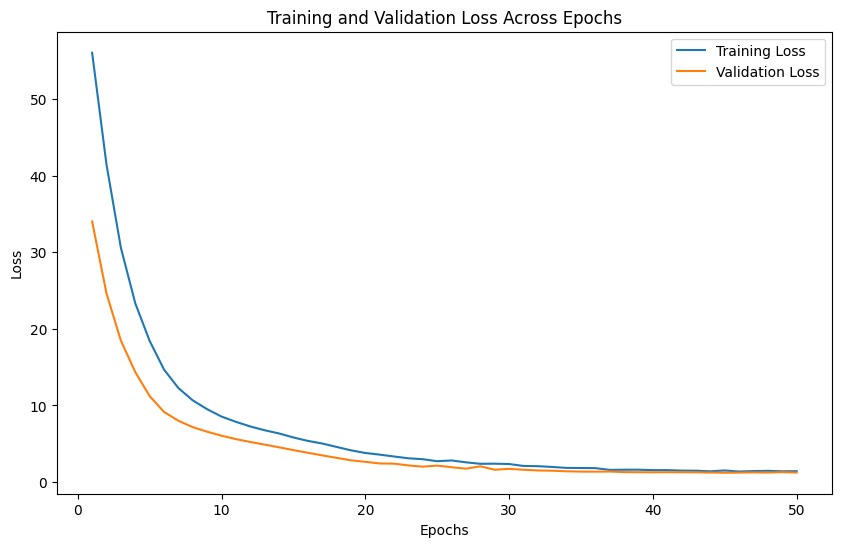

In [9]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# Convert test data to PyTorch tensors
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(x_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_r2 = r2_score(y_test_tensor.cpu(), test_outputs.cpu())

print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test R2: {test_r2:.4f}")


Test Loss: 1.3218
Test R2: 0.9735


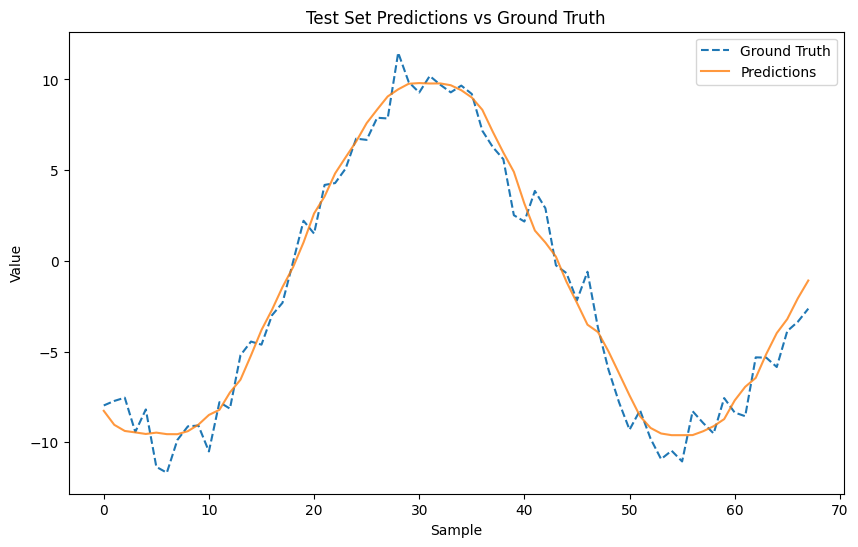

In [11]:
# Visualize the ground truth vs predictions
test_outputs_np = test_outputs.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label="Ground Truth", linestyle='--')
plt.plot(test_outputs_np, label="Predictions", alpha=0.8)
plt.title("Test Set Predictions vs Ground Truth")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.show()

# LSTM

Using device: cuda


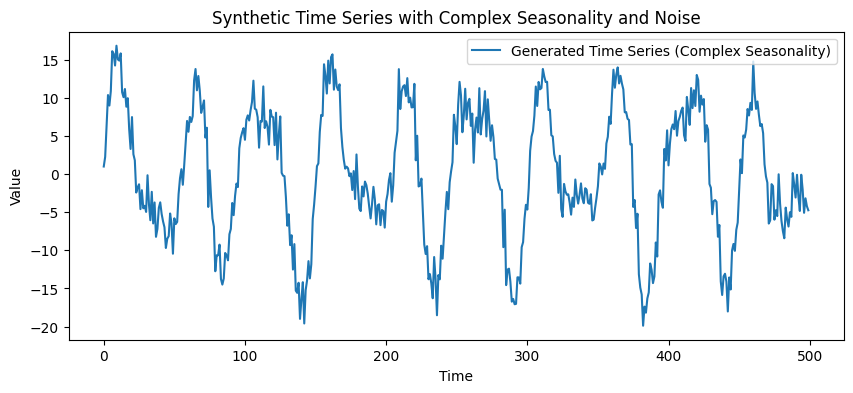

In [39]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Import tqdm for progress bar

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate synthetic time series data with complex seasonality
np.random.seed(42)
data_length = 500
time = np.arange(0, data_length)
seasonal_component_1 = 10 * np.sin(2 * np.pi * time / 50)  # Frequency 1
seasonal_component_2 = 5 * np.sin(2 * np.pi * time / 30)   # Frequency 2
seasonal_component_3 = 3 * np.sin(2 * np.pi * time / 80)   # Frequency 3
noise = np.random.normal(0, 2, size=data_length)           # Random noise
data = seasonal_component_1 + seasonal_component_2 + seasonal_component_3 + noise

# Plot the generated dataset
plt.figure(figsize=(10, 4))
plt.plot(time, data, label="Generated Time Series (Complex Seasonality)")
plt.title("Synthetic Time Series with Complex Seasonality and Noise")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [40]:

# Scaling the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Function to create dataset for LSTM
def create_dataset(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])  # Predict next time step
    return np.array(x), np.array(y)

# Sequence length
seq_length = 50

# Create input/output sequences
x, y = create_dataset(data_scaled, seq_length)

# Split the data into training, validation, and testing sets
train_size = int(len(x) * 0.7)
val_size = int(len(x) * 0.2)
test_size = len(x) - train_size - val_size

x_train, x_val, x_test = x[:train_size], x[train_size:train_size + val_size], x[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Convert the data into PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [41]:

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Instantiate the model and move it to the device (GPU or CPU)
model = LSTMModel(input_size=1, hidden_size=64, output_size=1, num_layers=2).to(device)


In [42]:

# Loss function (RMSE) and optimizer (Adam)
criterion = nn.MSELoss()  # MSE will be used, but we'll compute RMSE manually
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 50  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop with tqdm progress bar
num_epochs = 500
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(x_train)
    train_loss = criterion(outputs, y_train)  # Compute MSE loss

    # Calculate R² score for training using sklearn's r2_score
    train_r2 = r2_score(y_train.cpu().numpy(), outputs.detach().cpu().numpy())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    train_r2_scores.append(train_r2)

    # Validation loss and R²
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)

        # Calculate R² score for validation
        val_r2 = r2_score(y_val.cpu().numpy(), val_outputs.detach().cpu().numpy())

        val_losses.append(val_loss.item())
        val_r2_scores.append(val_r2)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # Stop training if no improvement for 'patience' epochs

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train R²: {train_r2:.4f}, Val Loss: {val_loss.item():.4f}, Val R²: {val_r2:.4f}")


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 0.2168, Train R²: -3.1875, Val Loss: 0.1839, Val R²: -1.7100
Epoch [11/500], Train Loss: 0.0482, Train R²: 0.0690, Val Loss: 0.0657, Val R²: 0.0320
Epoch [21/500], Train Loss: 0.0453, Train R²: 0.1256, Val Loss: 0.0586, Val R²: 0.1358
Epoch [31/500], Train Loss: 0.0435, Train R²: 0.1606, Val Loss: 0.0546, Val R²: 0.1957
Epoch [41/500], Train Loss: 0.0388, Train R²: 0.2511, Val Loss: 0.0517, Val R²: 0.2388
Epoch [51/500], Train Loss: 0.0323, Train R²: 0.3769, Val Loss: 0.0405, Val R²: 0.4026
Epoch [61/500], Train Loss: 0.0256, Train R²: 0.5062, Val Loss: 0.0306, Val R²: 0.5493
Epoch [71/500], Train Loss: 0.0158, Train R²: 0.6955, Val Loss: 0.0182, Val R²: 0.7321
Epoch [81/500], Train Loss: 0.0098, Train R²: 0.8099, Val Loss: 0.0113, Val R²: 0.8329
Epoch [91/500], Train Loss: 0.0069, Train R²: 0.8670, Val Loss: 0.0086, Val R²: 0.8727
Epoch [101/500], Train Loss: 0.0057, Train R²: 0.8908, Val Loss: 0.0071, Val R²: 0.8960
Epoch [111/500], Train Loss: 0.0052, Trai

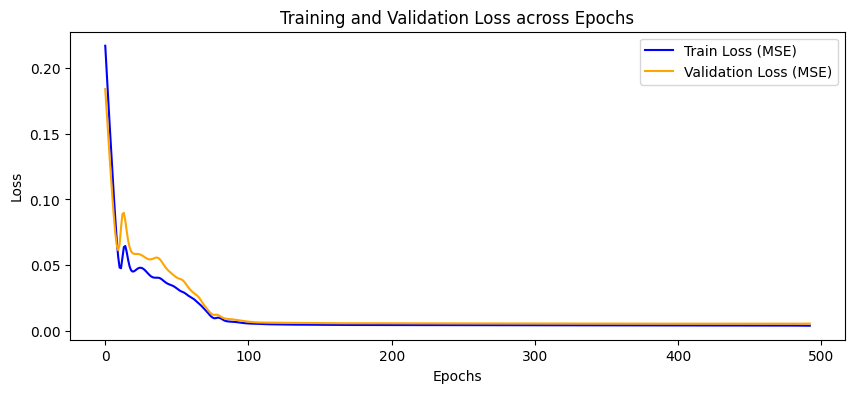

In [43]:

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss (MSE)', color='blue')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss (MSE)', color='orange')
plt.title('Training and Validation Loss across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




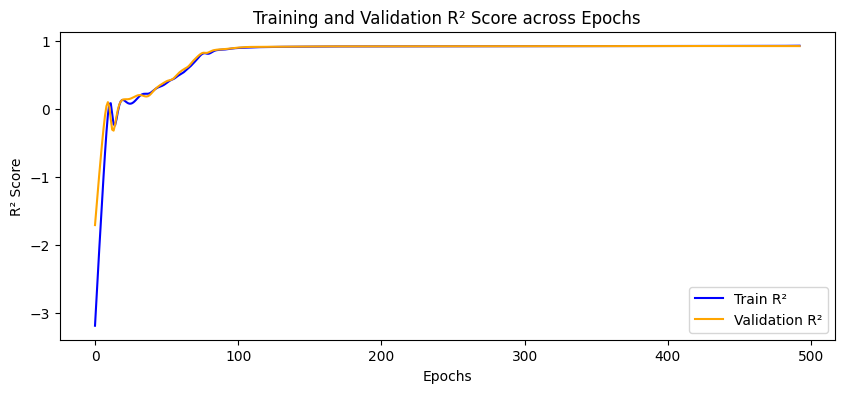

In [44]:
# Plot R² scores for training and validation
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_r2_scores)), train_r2_scores, label='Train R²', color='blue')
plt.plot(range(len(val_r2_scores)), val_r2_scores, label='Validation R²', color='orange')
plt.title('Training and Validation R² Score across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

In [45]:
# Test the model and inverse transform the predictions
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_outputs = test_outputs.detach().cpu().numpy()  # Move to CPU after prediction
    test_outputs = scaler.inverse_transform(test_outputs)

# Inverse transform the actual values
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Flatten both arrays to ensure they are one-dimensional
y_test_actual = y_test_actual.flatten()
test_outputs = test_outputs.flatten()

# Ensure the length of both actual and predicted values is the same
assert len(y_test_actual) == len(test_outputs), f"Length mismatch: {len(y_test_actual)} vs {len(test_outputs)}"

# Calculate R² on test set
test_r2 = r2_score(y_test_actual, test_outputs)
print(f"R² Score on Test Set: {test_r2:.4f}")

# Calculate RMSE (Root Mean Squared Error) on Test Set
rmse = np.sqrt(mean_squared_error(y_test_actual, test_outputs))
print(f"RMSE on Test Set: {rmse:.4f}")

R² Score on Test Set: 0.7603
RMSE on Test Set: 2.9430


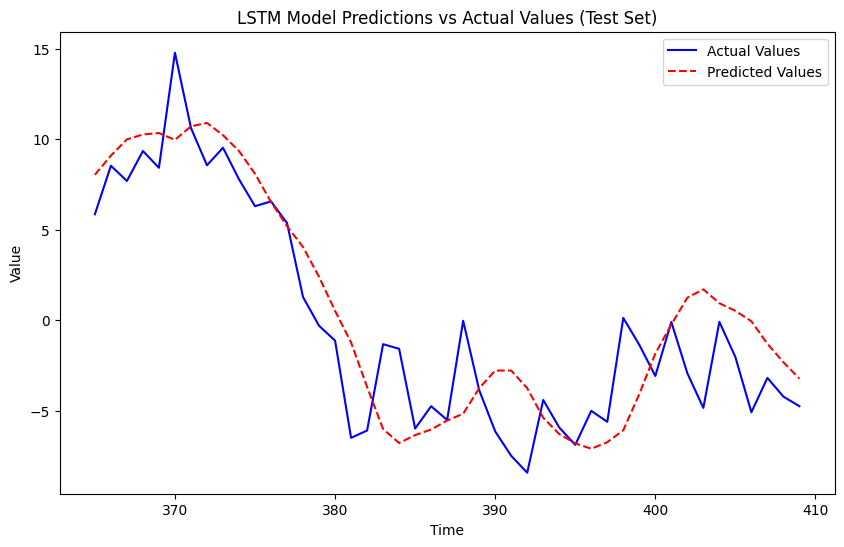

In [46]:

# Ensure the time axis matches the length of the test data (45 time steps)
time_test = time[train_size + seq_length:train_size + seq_length + len(test_outputs)]  # Adjust time for test set

# Plot predictions vs actual values on the test set
plt.figure(figsize=(10, 6))
plt.plot(time_test, y_test_actual, label="Actual Values", color='blue')
plt.plot(time_test, test_outputs, label="Predicted Values", color='red', linestyle='--')
plt.title('LSTM Model Predictions vs Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Multivariate Time Series Forecasting using Hourly Pollution Levels in Beijing  Dataset

In [53]:
! git clone https://github.com/jbrownlee/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 296 (delta 66), reused 61 (delta 61), pack-reused 215 (from 1)
Receiving objects: 100% (296/296), 220.50 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [56]:
# Importing necessary libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam


In [57]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('Datasets/pollution.csv')

# Display the first few rows to understand the structure
data.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [58]:

# Convert year, month, day, and hour to a datetime column
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# Set the datetime column as the index
data.set_index('datetime', inplace=True)

# Drop the original year, month, day, hour columns as they are already represented in datetime
data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Handle missing values in the pm2.5 column
data['pm2.5'].fillna(data['pm2.5'].mean(), inplace=True)

# Check for any remaining missing values
print("Missing values after imputation:")
print(data.isnull().sum())

# Create additional features
# - Day of the week (0=Monday, 6=Sunday)
data['weekday'] = data.index.weekday
# - Hour of the day (0-23)
data['hour_of_day'] = data.index.hour

# Optional: Scaling the numerical features using StandardScaler
scaler = StandardScaler()
# Scale selected features (make sure you are scaling numerical features only)
data[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']] = scaler.fit_transform(
    data[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']]
)

# Display the processed data
print("Processed data:")
data.head()




Missing values after imputation:
No       0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64
Processed data:


<ipython-input-58-91771e0812ef>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['pm2.5'].fillna(data['pm2.5'].mean(), inplace=True)


,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,weekday,hour_of_day
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,0.0,-1.580878,-1.922250,0.443328,NW,-0.441894,-0.069353,-0.137667,4,0
2010-01-01 01:00:00,2,0.0,-1.580878,-2.004228,0.345943,NW,-0.379306,-0.069353,-0.137667,4,1
2010-01-01 02:00:00,3,0.0,-1.580878,-1.922250,0.248559,NW,-0.343514,-0.069353,-0.137667,4,2
2010-01-01 03:00:00,4,0.0,-1.580878,-2.168183,0.248559,NW,-0.280926,-0.069353,-0.137667,4,3
2010-01-01 04:00:00,5,0.0,-1.511594,-2.004228,0.151174,NW,-0.218339,-0.069353,-0.137667,4,4


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           43824 non-null  int64  
 1   pm2.5        43824 non-null  float64
 2   DEWP         43824 non-null  float64
 3   TEMP         43824 non-null  float64
 4   PRES         43824 non-null  float64
 5   cbwd         43824 non-null  object 
 6   Iws          43824 non-null  float64
 7   Is           43824 non-null  float64
 8   Ir           43824 non-null  float64
 9   weekday      43824 non-null  int32  
 10  hour_of_day  43824 non-null  int32  
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 3.7+ MB


In [61]:
# Save the preprocessed data (if needed)
data.to_csv('preprocessed_pollution.csv', index=True)

In [62]:
data.drop(columns=['cbwd'],inplace=True)

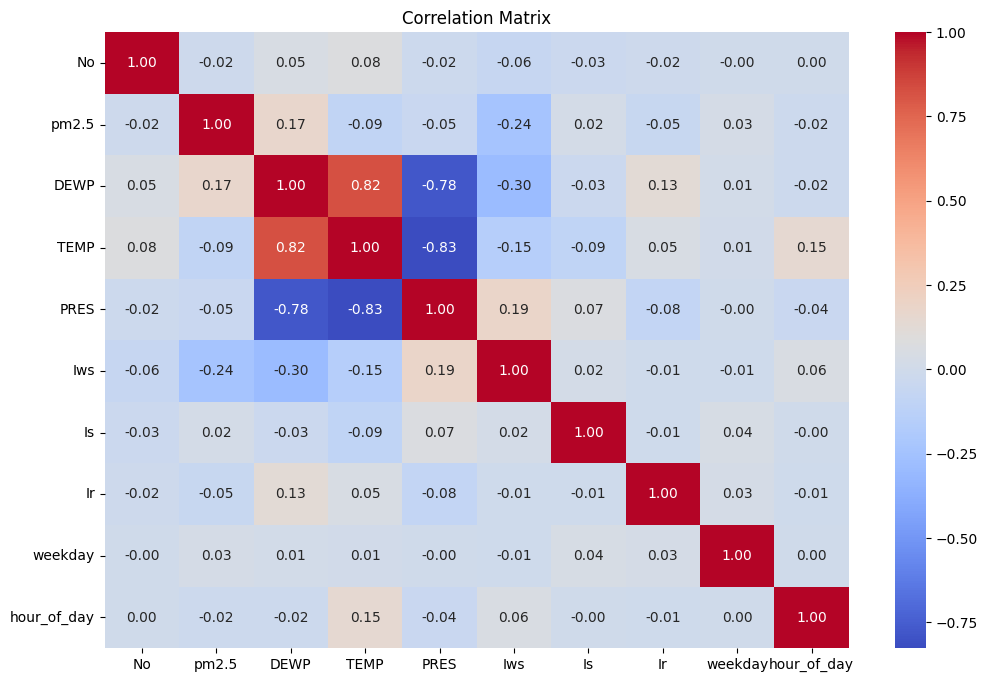

Feature importances from Random Forest:
       Feature  Importance
0           No    0.341000
1         DEWP    0.203690
2         TEMP    0.154294
4          Iws    0.090770
3         PRES    0.087945
8  hour_of_day    0.061469
7      weekday    0.054875
6           Ir    0.005017
5           Is    0.000939
Lasso Regression coefficients:
       Feature  Lasso Coefficient
1         DEWP           0.688992
8  hour_of_day           0.111730
7      weekday           0.020876
0           No          -0.000000
5           Is          -0.016819
6           Ir          -0.106792
4          Iws          -0.135829
3         PRES          -0.163455
2         TEMP          -0.822069


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Feature engineering: Remove features that are redundant or directly correlated with target
# Assuming 'pm2.5' is the target, we can exclude it from the feature set
X = data.drop(columns=['pm2.5'])
y = data['pm2.5']

# Scale the features for better performance of models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------- Step 1: Correlation Matrix -----------------------------
# Create a correlation matrix to identify which features are most correlated with 'pm2.5'
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# ---------------------------- Step 2: Feature Importance via Random Forest -----------------------------
# Fit a Random Forest Regressor and extract feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature importances from Random Forest:")
print(feature_importances)

# ---------------------------- Step 3: Lasso Regression -----------------------------
# Lasso (L1 regularization) for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Get coefficients from Lasso
lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Lasso Coefficient': lasso.coef_
}).sort_values(by='Lasso Coefficient', ascending=False)

print("Lasso Regression coefficients:")
print(lasso_coefficients)


In [65]:

# ---------------------------- Step 4: Recursive Feature Elimination (RFE) -----------------------------
# Use RFE for feature selection (starting with all features)
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=6, step=1)
selector.fit(X_scaled, y)

# Get the selected features from RFE
selected_features_rfe = pd.DataFrame({
    'Feature': X.columns,
    'Selected': selector.support_,
    'Ranking': selector.ranking_
}).sort_values(by='Ranking')

print("RFE Selected Features:")
print(selected_features_rfe[selected_features_rfe['Selected'] == True])




RFE Selected Features:
       Feature  Selected  Ranking
0           No      True        1
1         DEWP      True        1
2         TEMP      True        1
3         PRES      True        1
4          Iws      True        1
8  hour_of_day      True        1


In [71]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm


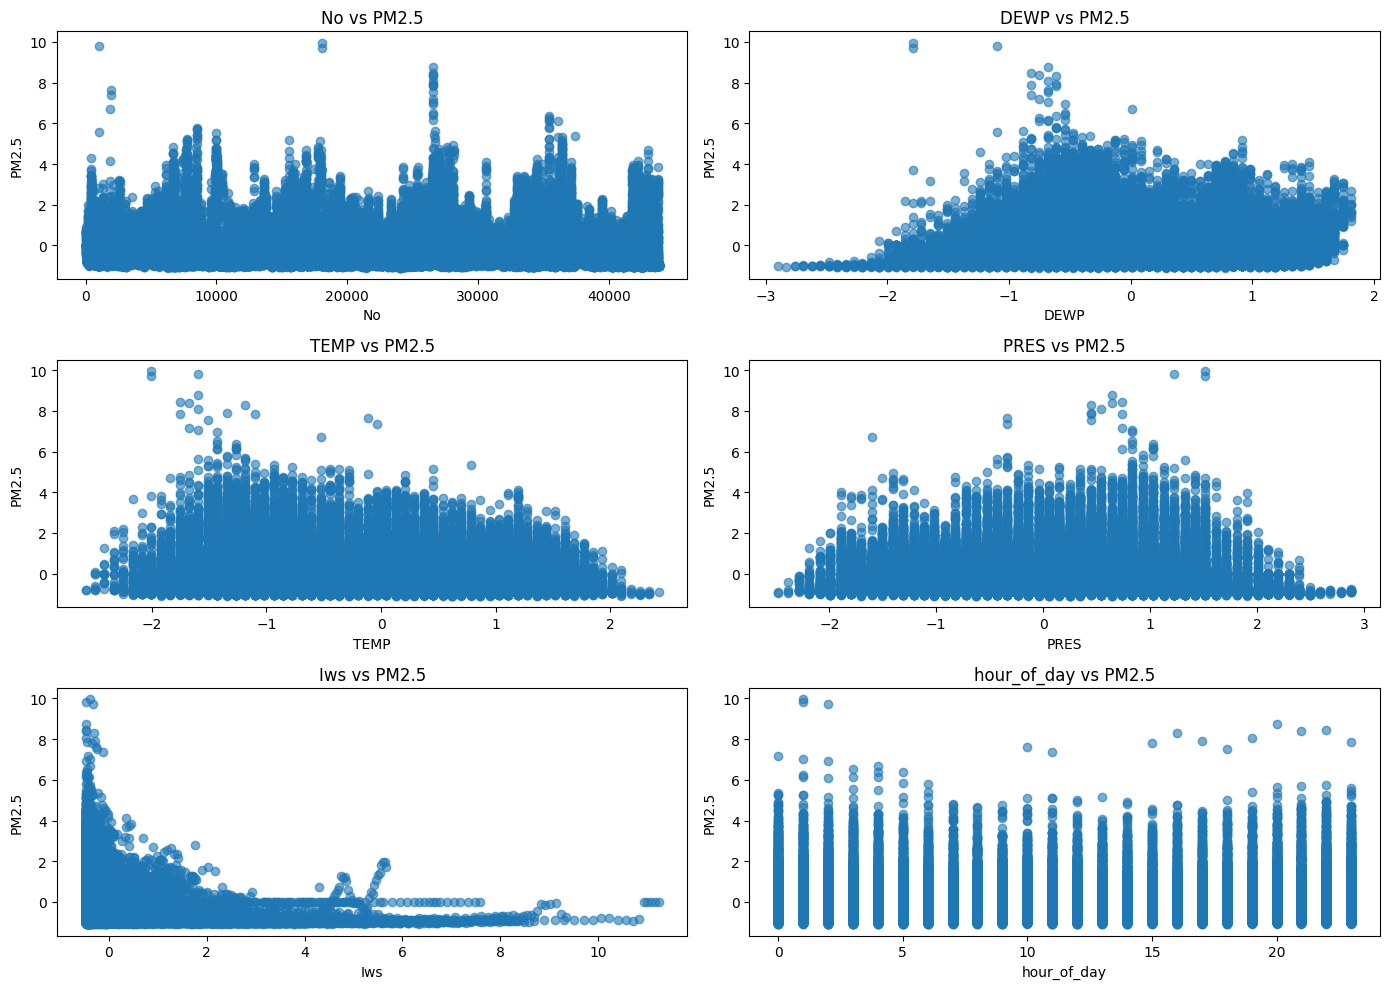

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime', parse_dates=True)

# Select the most important features (excluding PM2.5)
selected_features = ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'hour_of_day']

# Set up the plotting area (one plot for each feature)
plt.figure(figsize=(14, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    plt.scatter(data[feature], data['pm2.5'], alpha=0.6)
    plt.title(f'{feature} vs PM2.5')
    plt.xlabel(feature)
    plt.ylabel('PM2.5')

plt.tight_layout()
plt.show()


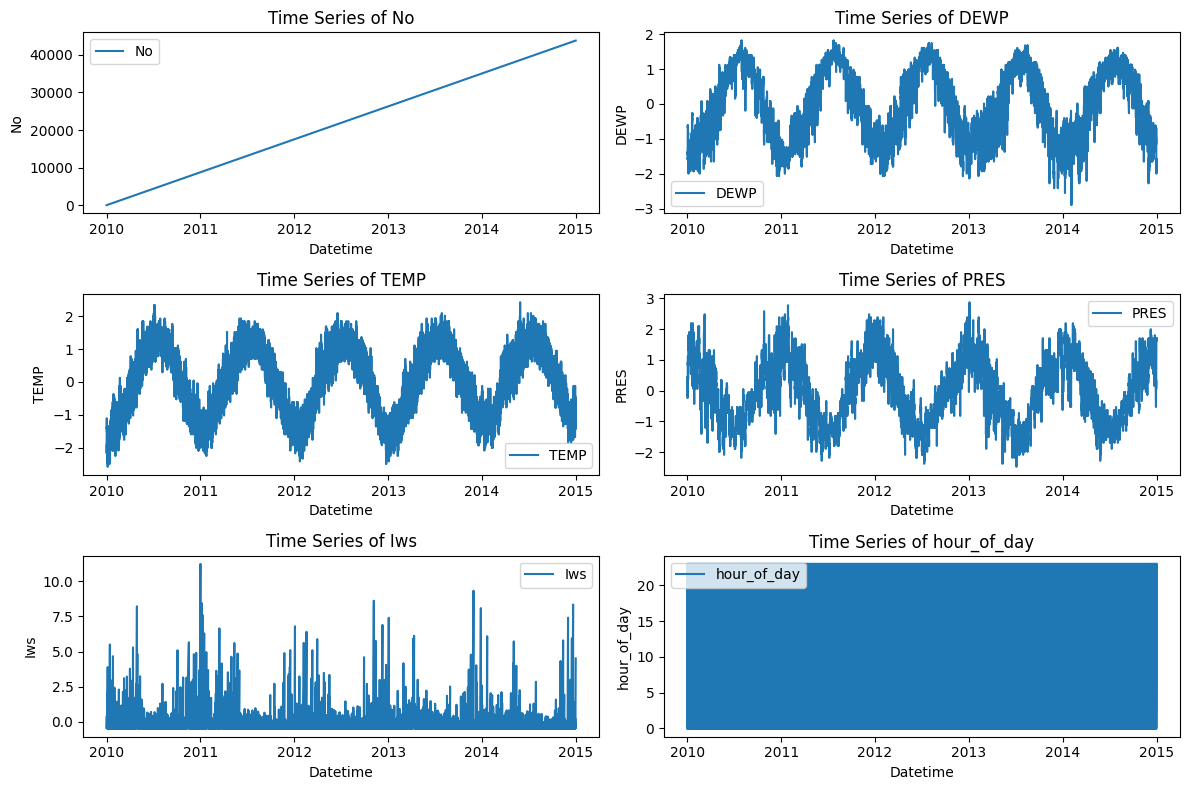

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime', parse_dates=True)

# Select the most important features
selected_features = ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'hour_of_day']
df_selected = data[selected_features]

# Plot time series for selected features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    plt.plot(df_selected.index, df_selected[feature], label=feature)
    plt.title(f'Time Series of {feature}')
    plt.xlabel('Datetime')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()


In [76]:

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime')

# Select the most important features from feature engineering
selected_features = ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'hour_of_day']


X = data[selected_features].values
y = data['pm2.5'].values

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Reshape data to fit LSTM input shape (samples, time_steps, features)
def create_dataset(X, y, time_steps=24):
    X_data, y_data = [], []
    for i in range(len(X) - time_steps):
        X_data.append(X[i:i + time_steps])
        y_data.append(y[i + time_steps])
    return np.array(X_data), np.array(y_data)

# Create dataset with a time step of 24 hours (1 day)
time_steps = 24
X_data, y_data = create_dataset(X_scaled, y_scaled, time_steps)

# Split the dataset into training, validation, and test sets
train_size = int(len(X_data) * 0.7)
val_size = int(len(X_data) * 0.2)
test_size = len(X_data) - train_size - val_size

X_train, X_val, X_test = X_data[:train_size], X_data[train_size:train_size + val_size], X_data[train_size + val_size:]
y_train, y_val, y_test = y_data[:train_size], y_data[train_size:train_size + val_size], y_data[train_size + val_size:]

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [77]:

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Get the last time step's prediction
        return predictions

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[2]  # Number of features (5 features selected)
model = LSTMModel(input_size=input_size)

# Move the model to the device (GPU or CPU)
model.to(device)

criterion = nn.MSELoss()  # MSE loss (to compute RMSE manually)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [78]:

# Early stopping parameters
patience = 100  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop with tqdm progress bar
num_epochs = 500
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()

    # Move data to the device (GPU or CPU)
    X_train_tensor_device = X_train_tensor.to(device)
    y_train_tensor_device = y_train_tensor.to(device)

    # Forward pass
    outputs = model(X_train_tensor_device)
    train_loss = criterion(outputs, y_train_tensor_device)  # Compute MSE loss

    # Calculate R² score for training using sklearn's r2_score
    train_r2 = r2_score(y_train_tensor_device.cpu().numpy(), outputs.detach().cpu().numpy())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    train_r2_scores.append(train_r2)

    # Validation loss and R²
    model.eval()
    with torch.no_grad():
        X_val_tensor_device = X_val_tensor.to(device)
        y_val_tensor_device = y_val_tensor.to(device)

        val_outputs = model(X_val_tensor_device)
        val_loss = criterion(val_outputs, y_val_tensor_device)

        # Calculate R² score for validation
        val_r2 = r2_score(y_val_tensor_device.cpu().numpy(), val_outputs.detach().cpu().numpy())

        val_losses.append(val_loss.item())
        val_r2_scores.append(val_r2)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # Stop training if no improvement for 'patience' epochs

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train R²: {train_r2:.4f}, Val Loss: {val_loss.item():.4f}, Val R²: {val_r2:.4f}")


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 1.0022, Train R²: 0.0058, Val Loss: 0.9725, Val R²: 0.0117
Epoch [11/500], Train Loss: 0.9355, Train R²: 0.0720, Val Loss: 0.9363, Val R²: 0.0485
Epoch [21/500], Train Loss: 0.8471, Train R²: 0.1597, Val Loss: 0.8608, Val R²: 0.1253
Epoch [31/500], Train Loss: 0.7401, Train R²: 0.2659, Val Loss: 0.6862, Val R²: 0.3027
Epoch [41/500], Train Loss: 0.6876, Train R²: 0.3179, Val Loss: 0.7165, Val R²: 0.2719
Epoch [51/500], Train Loss: 0.6591, Train R²: 0.3462, Val Loss: 0.6399, Val R²: 0.3498
Epoch [61/500], Train Loss: 0.6397, Train R²: 0.3654, Val Loss: 0.6711, Val R²: 0.3181
Epoch [71/500], Train Loss: 0.6196, Train R²: 0.3854, Val Loss: 0.6274, Val R²: 0.3624
Epoch [81/500], Train Loss: 0.5963, Train R²: 0.4085, Val Loss: 0.6274, Val R²: 0.3624
Epoch [91/500], Train Loss: 0.5764, Train R²: 0.4282, Val Loss: 0.6120, Val R²: 0.3781
Epoch [101/500], Train Loss: 0.5575, Train R²: 0.4470, Val Loss: 0.6324, Val R²: 0.3574
Epoch [111/500], Train Loss: 0.5431, Train 

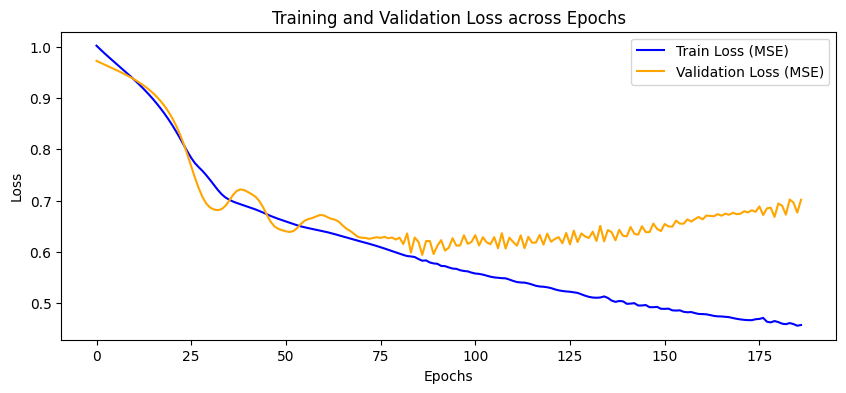

In [79]:

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss (MSE)', color='blue')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss (MSE)', color='orange')
plt.title('Training and Validation Loss across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


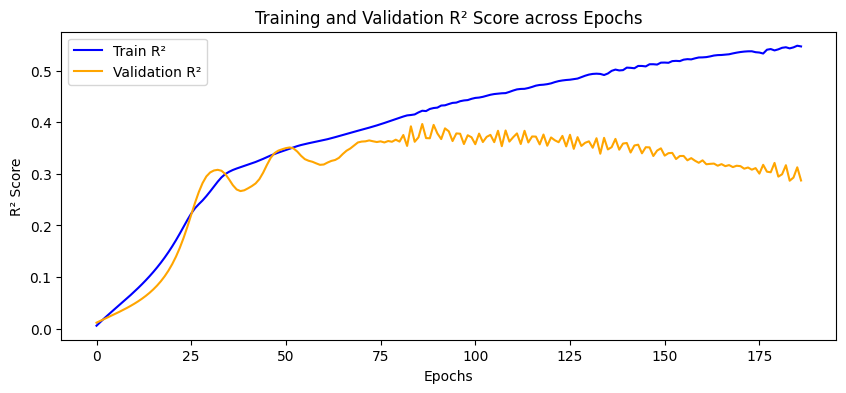

In [80]:

# Plot R² scores for training and validation
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_r2_scores)), train_r2_scores, label='Train R²', color='blue')
plt.plot(range(len(val_r2_scores)), val_r2_scores, label='Validation R²', color='orange')
plt.title('Training and Validation R² Score across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()


In [81]:

# Test the model and inverse transform the predictions
model.eval()
with torch.no_grad():
    X_test_tensor_device = X_test_tensor.to(device)
    test_outputs = model(X_test_tensor_device)
    test_outputs = test_outputs.detach().cpu().numpy()  # Move to CPU after prediction
    test_outputs = scaler_y.inverse_transform(test_outputs)

# Inverse transform the actual values
y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# Flatten both arrays to ensure they are one-dimensional
y_test_actual = y_test_actual.flatten()
test_outputs = test_outputs.flatten()

# Ensure the length of both actual and predicted values is the same
assert len(y_test_actual) == len(test_outputs), f"Length mismatch: {len(y_test_actual)} vs {len(test_outputs)}"

# Calculate R² on test set
test_r2 = r2_score(y_test_actual, test_outputs)
print(f"R² Score on Test Set: {test_r2:.4f}")

# Calculate RMSE (Root Mean Squared Error) on Test Set
rmse = np.sqrt(mean_squared_error(y_test_actual, test_outputs))
print(f"RMSE on Test Set: {rmse:.4f}")


R² Score on Test Set: 0.3821
RMSE on Test Set: 0.7732


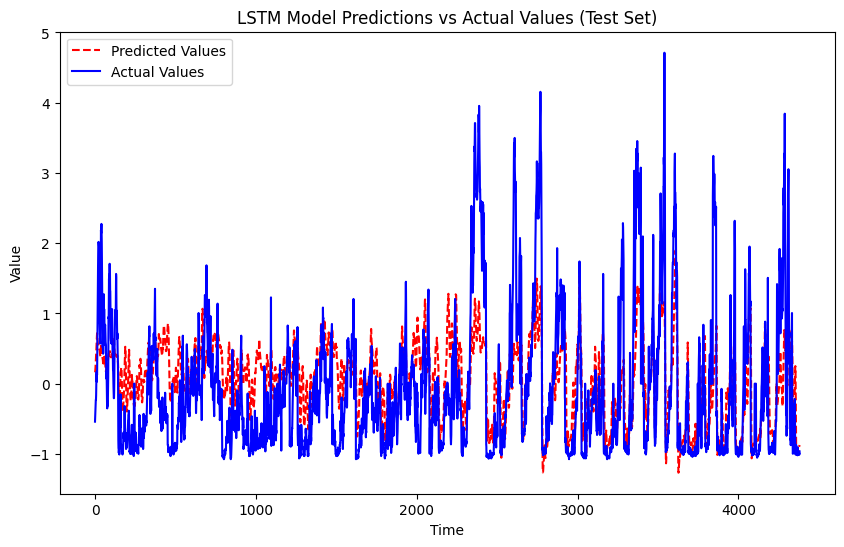

In [82]:

# Plot predictions vs actual values on the test set
plt.figure(figsize=(10, 6))
plt.plot(test_outputs, label="Predicted Values", color='red', linestyle='--')
plt.plot(y_test_actual, label="Actual Values", color='blue')
plt.title('LSTM Model Predictions vs Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


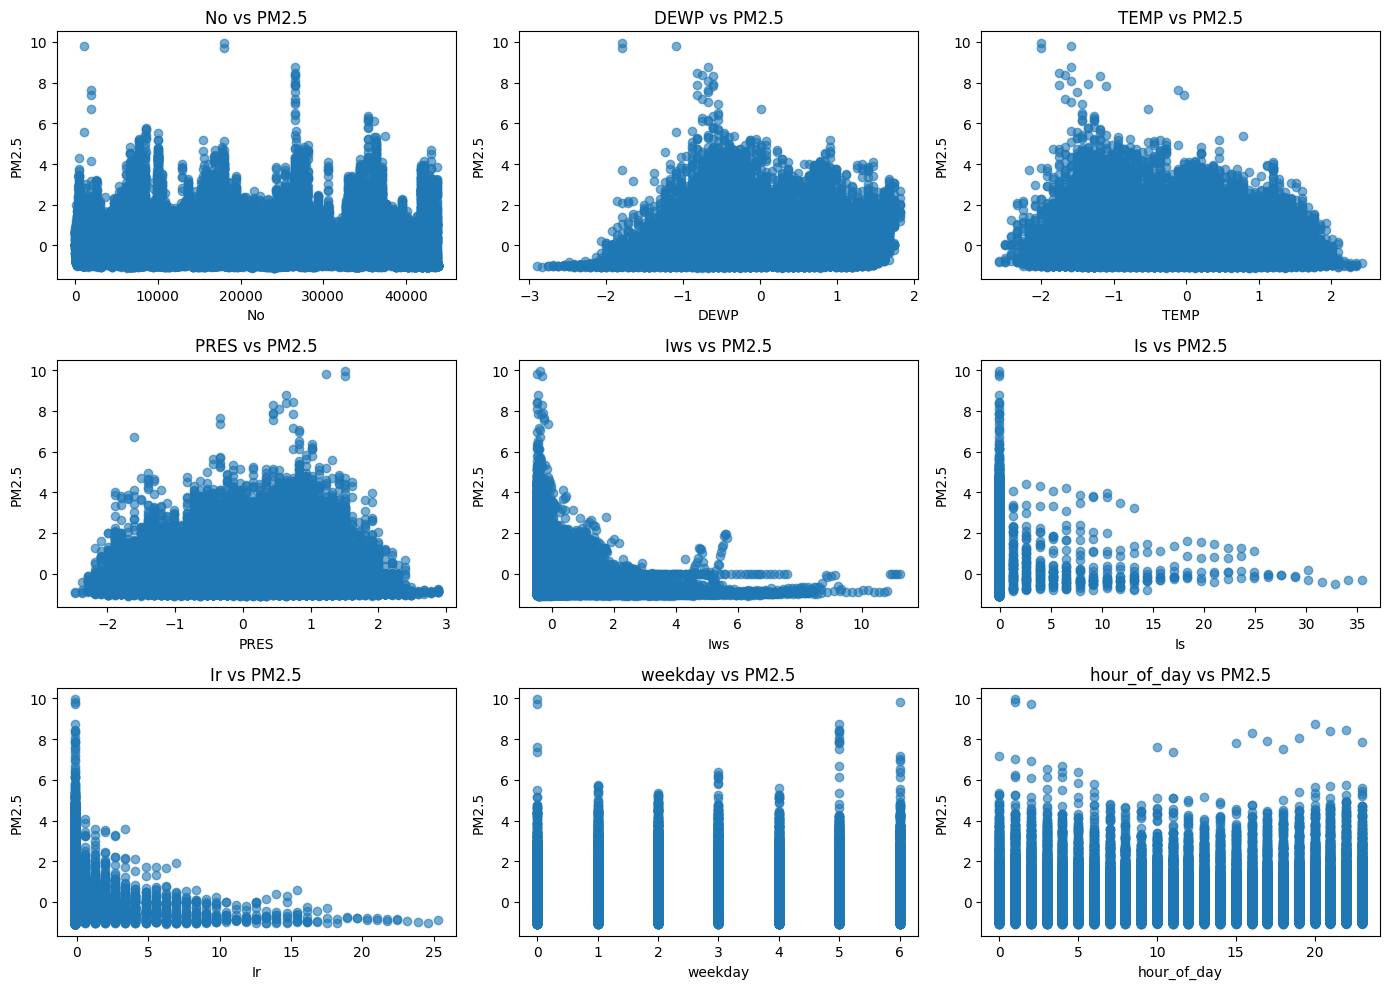

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime', parse_dates=True)

# Select the most important features (excluding PM2.5)
selected_features = data.drop(columns=['pm2.5','cbwd']).columns

# Set up the plotting area (one plot for each feature)
plt.figure(figsize=(14, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 3, i)
    plt.scatter(data[feature], data['pm2.5'], alpha=0.6)
    plt.title(f'{feature} vs PM2.5')
    plt.xlabel(feature)
    plt.ylabel('PM2.5')

plt.tight_layout()
plt.show()


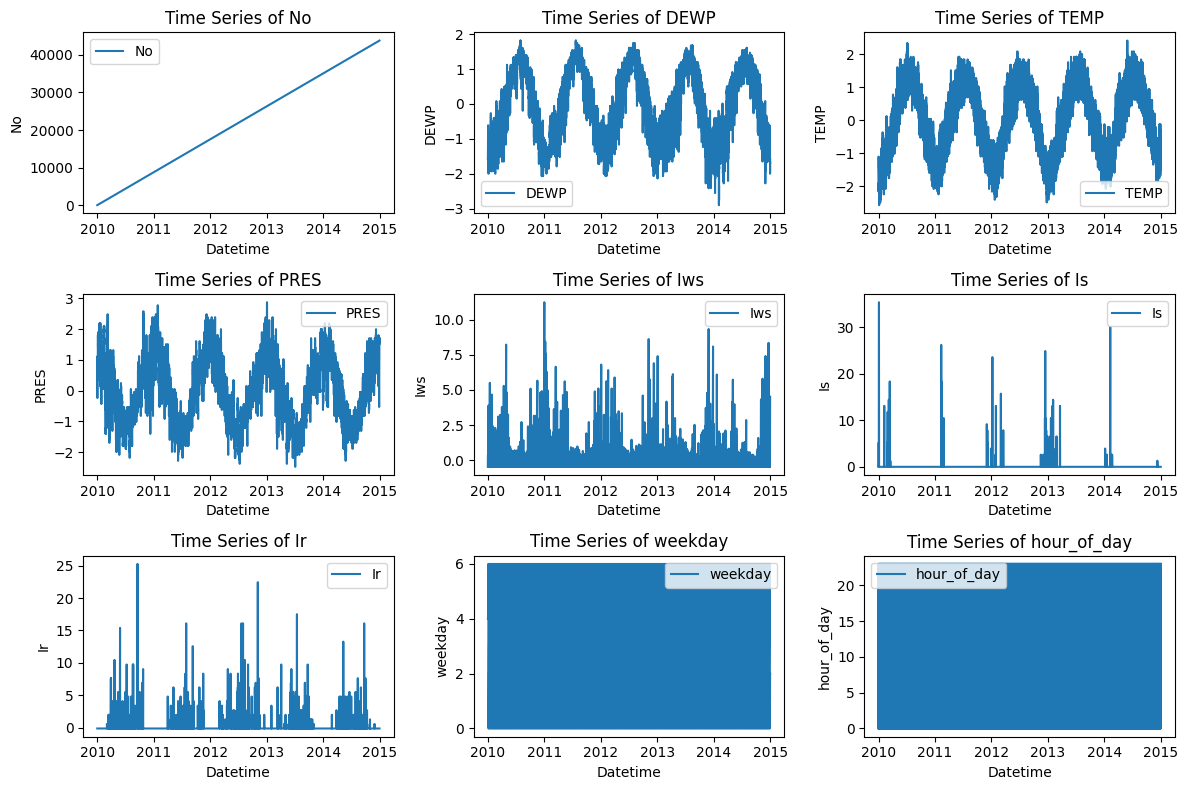

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime', parse_dates=True)

# Select the most important features
selected_features = data.drop(columns=['pm2.5','cbwd']).columns
df_selected = data[selected_features]

# Plot time series for selected features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_selected.index, df_selected[feature], label=feature)
    plt.title(f'Time Series of {feature}')
    plt.xlabel('Datetime')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()


In [87]:

# Load the preprocessed data
data = pd.read_csv('preprocessed_pollution.csv', index_col='datetime')

# Select the most important features from feature engineering
selected_features = ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'hour_of_day']


X = data[selected_features].values
y = data['pm2.5'].values

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Reshape data to fit LSTM input shape (samples, time_steps, features)
def create_dataset(X, y, time_steps=24):
    X_data, y_data = [], []
    for i in range(len(X) - time_steps):
        X_data.append(X[i:i + time_steps])
        y_data.append(y[i + time_steps])
    return np.array(X_data), np.array(y_data)

# Create dataset with a time step of 24 hours (1 day)
time_steps = 24
X_data, y_data = create_dataset(X_scaled, y_scaled, time_steps)

# Split the dataset into training, validation, and test sets
train_size = int(len(X_data) * 0.7)
val_size = int(len(X_data) * 0.2)
test_size = len(X_data) - train_size - val_size

X_train, X_val, X_test = X_data[:train_size], X_data[train_size:train_size + val_size], X_data[train_size + val_size:]
y_train, y_val, y_test = y_data[:train_size], y_data[train_size:train_size + val_size], y_data[train_size + val_size:]

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [88]:

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Get the last time step's prediction
        return predictions

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[2]  # Number of features (5 features selected)
model = LSTMModel(input_size=input_size)

# Move the model to the device (GPU or CPU)
model.to(device)

criterion = nn.MSELoss()  # MSE loss (to compute RMSE manually)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [89]:

# Early stopping parameters
patience = 100  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop with tqdm progress bar
num_epochs = 500
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()

    # Move data to the device (GPU or CPU)
    X_train_tensor_device = X_train_tensor.to(device)
    y_train_tensor_device = y_train_tensor.to(device)

    # Forward pass
    outputs = model(X_train_tensor_device)
    train_loss = criterion(outputs, y_train_tensor_device)  # Compute MSE loss

    # Calculate R² score for training using sklearn's r2_score
    train_r2 = r2_score(y_train_tensor_device.cpu().numpy(), outputs.detach().cpu().numpy())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    train_r2_scores.append(train_r2)

    # Validation loss and R²
    model.eval()
    with torch.no_grad():
        X_val_tensor_device = X_val_tensor.to(device)
        y_val_tensor_device = y_val_tensor.to(device)

        val_outputs = model(X_val_tensor_device)
        val_loss = criterion(val_outputs, y_val_tensor_device)

        # Calculate R² score for validation
        val_r2 = r2_score(y_val_tensor_device.cpu().numpy(), val_outputs.detach().cpu().numpy())

        val_losses.append(val_loss.item())
        val_r2_scores.append(val_r2)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # Stop training if no improvement for 'patience' epochs

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train R²: {train_r2:.4f}, Val Loss: {val_loss.item():.4f}, Val R²: {val_r2:.4f}")


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 1.0090, Train R²: -0.0009, Val Loss: 1.0064, Val R²: -0.0226
Epoch [11/500], Train Loss: 0.9496, Train R²: 0.0580, Val Loss: 0.9644, Val R²: 0.0201
Epoch [21/500], Train Loss: 0.8846, Train R²: 0.1225, Val Loss: 0.8988, Val R²: 0.0867
Epoch [31/500], Train Loss: 0.7774, Train R²: 0.2288, Val Loss: 0.7337, Val R²: 0.2545
Epoch [41/500], Train Loss: 0.6946, Train R²: 0.3109, Val Loss: 0.6815, Val R²: 0.3075
Epoch [51/500], Train Loss: 0.6644, Train R²: 0.3409, Val Loss: 0.6385, Val R²: 0.3512
Epoch [61/500], Train Loss: 0.6401, Train R²: 0.3650, Val Loss: 0.6290, Val R²: 0.3609
Epoch [71/500], Train Loss: 0.6200, Train R²: 0.3849, Val Loss: 0.6209, Val R²: 0.3691
Epoch [81/500], Train Loss: 0.5943, Train R²: 0.4105, Val Loss: 0.6121, Val R²: 0.3780
Epoch [91/500], Train Loss: 0.5726, Train R²: 0.4320, Val Loss: 0.6144, Val R²: 0.3757
Epoch [101/500], Train Loss: 0.5540, Train R²: 0.4504, Val Loss: 0.6186, Val R²: 0.3714
Epoch [111/500], Train Loss: 0.5394, Trai

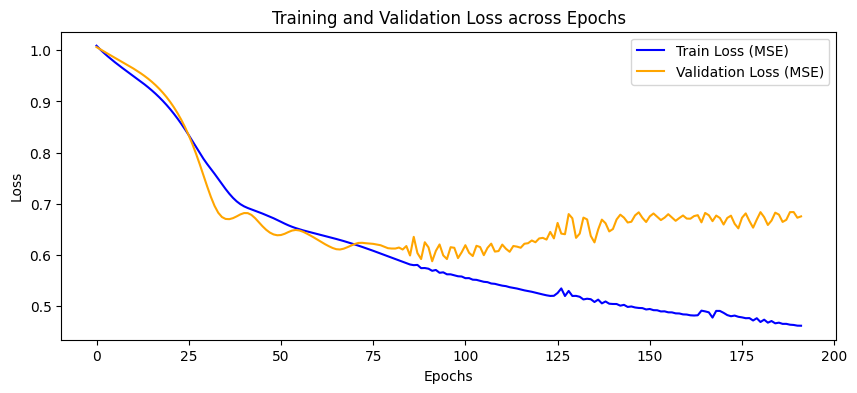

In [90]:

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss (MSE)', color='blue')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss (MSE)', color='orange')
plt.title('Training and Validation Loss across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


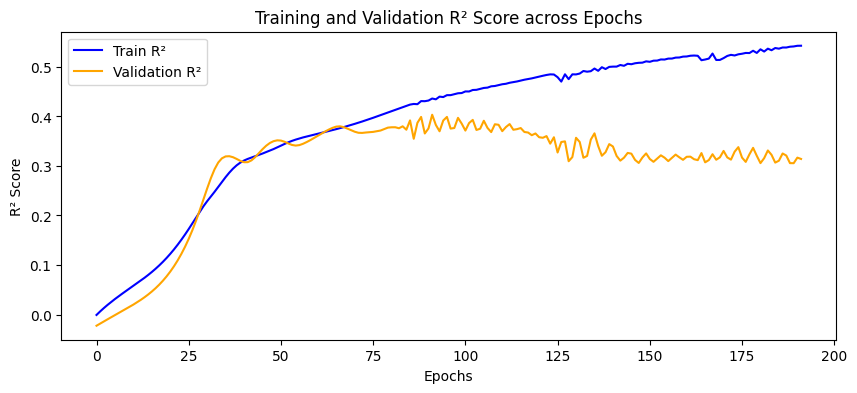

In [91]:

# Plot R² scores for training and validation
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_r2_scores)), train_r2_scores, label='Train R²', color='blue')
plt.plot(range(len(val_r2_scores)), val_r2_scores, label='Validation R²', color='orange')
plt.title('Training and Validation R² Score across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()


In [92]:

# Test the model and inverse transform the predictions
model.eval()
with torch.no_grad():
    X_test_tensor_device = X_test_tensor.to(device)
    test_outputs = model(X_test_tensor_device)
    test_outputs = test_outputs.detach().cpu().numpy()  # Move to CPU after prediction
    test_outputs = scaler_y.inverse_transform(test_outputs)

# Inverse transform the actual values
y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# Flatten both arrays to ensure they are one-dimensional
y_test_actual = y_test_actual.flatten()
test_outputs = test_outputs.flatten()

# Ensure the length of both actual and predicted values is the same
assert len(y_test_actual) == len(test_outputs), f"Length mismatch: {len(y_test_actual)} vs {len(test_outputs)}"

# Calculate R² on test set
test_r2 = r2_score(y_test_actual, test_outputs)
print(f"R² Score on Test Set: {test_r2:.4f}")

# Calculate RMSE (Root Mean Squared Error) on Test Set
rmse = np.sqrt(mean_squared_error(y_test_actual, test_outputs))
print(f"RMSE on Test Set: {rmse:.4f}")


R² Score on Test Set: 0.3689
RMSE on Test Set: 0.7814


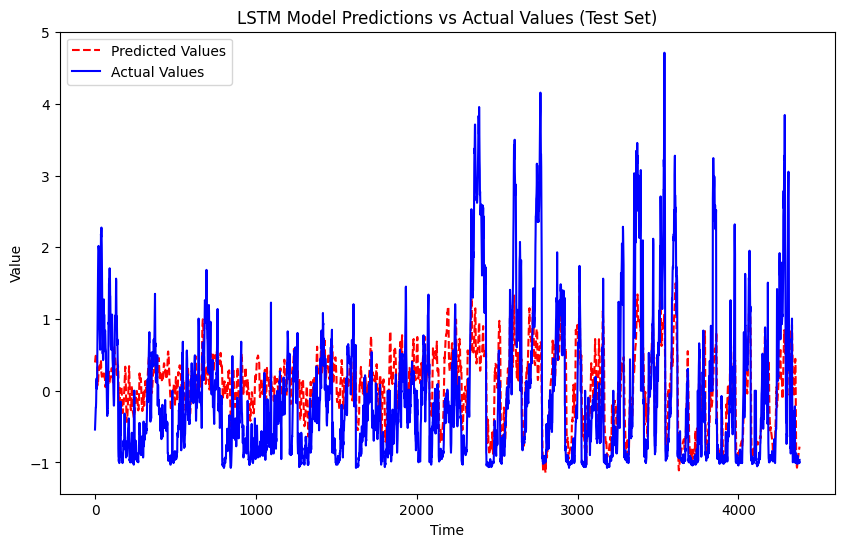

In [93]:

# Plot predictions vs actual values on the test set
plt.figure(figsize=(10, 6))
plt.plot(test_outputs, label="Predicted Values", color='red', linestyle='--')
plt.plot(y_test_actual, label="Actual Values", color='blue')
plt.title('LSTM Model Predictions vs Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
